In [8]:
import numpy as np
import matplotlib.pyplot as plt

## sin prediction

In [9]:
n_time = 10 
n_in = 1
n_mid = 20
n_out = 1

eta = 0.001
epochs = 51
batch_size = 8
interval = 5

**Generate Data**

In [10]:
sin_x = np.linspace(-2 * np.pi, 2 * np.pi)
sin_y = np.sin(sin_x) + 0.1 * np.random.rand(len(sin_x)) # add noise

n_sample = len(sin_x) - n_time
input_data = np.zeros((n_sample, n_time, n_in)) # 
correct_data = np.zeros((n_sample, n_out))
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i + n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i + n_time:i + n_time + 1]

**RNN Layer**

In [11]:
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper) # Xavier init
        self.v = np.random.randn(n, n) / np.sqrt(n)
        self.b = np.zeros(n)
    
    def forward(self, x, y_prev):
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)
        
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y ** 2)
        
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

class OutputLayer: # FC
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [12]:
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [13]:
def train(x_mb, t_mb):
    # RNN Layer forward propagation
    y_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i + 1, :] = y
        y_prev = y
        
    # output Layer
    output_layer.forward(y)
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    
    # RNN Layer backward propagation
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i + 1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev
    
    # parameters update
    rnn_layer.update(eta)
    output_layer.update(eta)
    
def predict(x_mb):
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y
    
    output_layer.forward(y)
    return output_layer.y

def get_error(x, t):
    y = predict(x)
    return 1.0 / 2.0 * np.sum(np.square(y - t)) # MSE

Epoch:1/51 Error:23.77577352818476


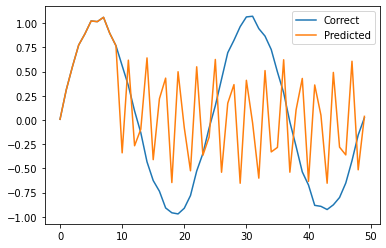

Epoch:6/51 Error:4.5126182802796535


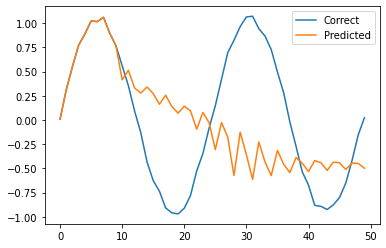

Epoch:11/51 Error:1.6531255499569228


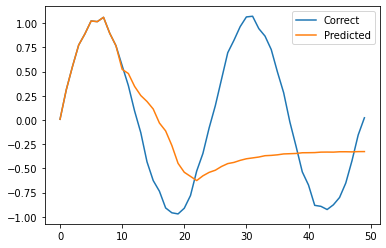

Epoch:16/51 Error:0.7797780424815934


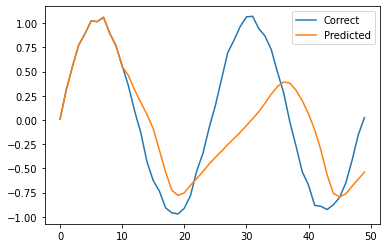

Epoch:21/51 Error:0.4876045764357421


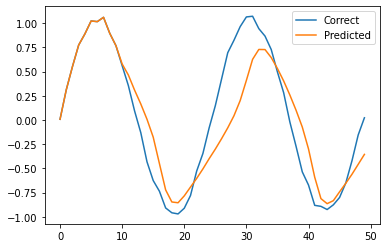

Epoch:26/51 Error:0.37266747733727845


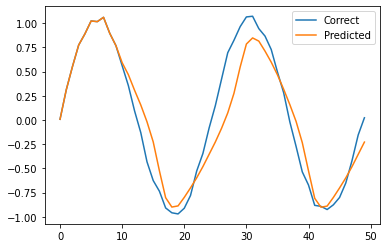

Epoch:31/51 Error:0.3168230336547395


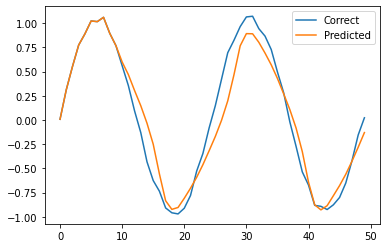

Epoch:36/51 Error:0.28124031031829866


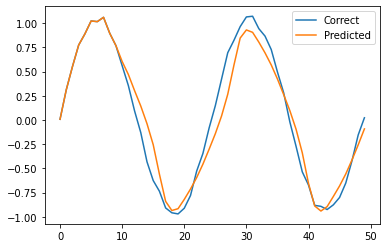

Epoch:41/51 Error:0.2544262024928698


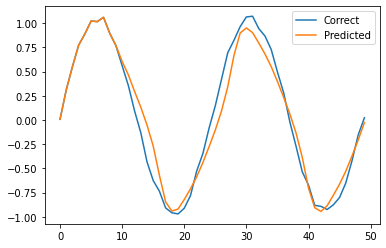

Epoch:46/51 Error:0.23162554166819957


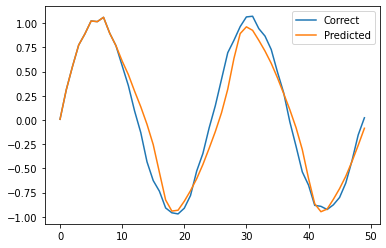

Epoch:51/51 Error:0.2119513881737033


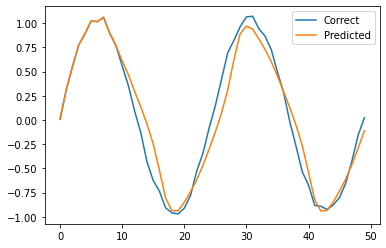

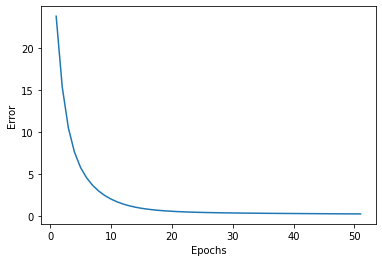

In [14]:
error_record = []
n_batch = len(input_data) // batch_size
for i in range(epochs):
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)
    
    for j in range(n_batch):
        mb_index = index_random[j * batch_size : (j + 1) * batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    if i % interval == 0:
        print("Epoch:" + str(i + 1) + "/" + str(epochs),
                "Error:" + str(error))
        predicted = input_data[0].reshape(-1).tolist()
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0,0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        
plt.plot(range(1, len(error_record) + 1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## binary adder

In [15]:
n_time = 8
n_in = 2
n_mid = 32
n_out = 1

eta = 0.01
n_learn = 5001
interval = 500

In [16]:
max_num = 2 ** n_time
binaries = np.zeros((max_num, n_time), dtype=int)
for i in range(max_num):
    num10 = i
    for j in range(n_time):
        pow2 = 2 ** (n_time - j - 1)
        binaries[i, j] = num10 // pow2
        num10 %= pow2

In [17]:
class RNNOutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1 / (1 + np.exp(-u)) # sigmoid
        
    def backward(self, x, y, t):
        delta = (y - t) * y * (1 - y)
        
        self.grad_w += np.dot(x.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [18]:
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = RNNOutputLayer(n_mid, n_out)

In [19]:
def train(x_mb, t_mb):
    y_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    y_out = np.zeros((len(x_mb), n_time, n_out))
    
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i + 1, :] = y
        y_prev = y
        
        output_layer.forward(y)
        y_out[:, i, :] = output_layer.y
    
    output_layer.reset_sum_grad()
    rnn_layer.reset_sum_grad()
    grad_y = 0
    for i in reversed(range(n_time)):
        x = y_rnn[:, i + 1, :]
        y = y_out[:, i, :]
        t = t_mb[:, i, :]
        output_layer.backward(x, y, t)
        grad_x_out = output_layer.grad_x
        
        x = x_mb[:, i, :]
        y = y_rnn[:, i + 1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y + grad_x_out)
        grad_y = rnn_layer.grad_y_prev
    
    rnn_layer.update(eta)
    output_layer.update(eta)
    return y_out

def get_error(y, t):
    return 1.0 / 2.0 * np.sum(np.square(y - t))

In [22]:
for i in range(n_learn):
    num1 = np.random.randint(max_num//2)
    num2 = np.random.randint(max_num//2)
    
    x1 = binaries[num1]
    x2 = binaries[num2]
    x_in = np.zeros((1, n_time, n_in))
    x_in[0, :, 0] = x1
    x_in[0, :, 1] = x2
    x_in = np.flip(x_in, axis=1)
    
    t = binaries[num1 + num2]
    t_in = t.reshape(1, n_time, n_out)
    t_in = np.flip(t_in, axis=1)
    
    y_out = train(x_in, t_in)
    y = np.flip(y_out, axis=1).reshape(-1)
    
    error = get_error(y_out, t_in)
    
    if i % interval == 0:
        y2 = np.where(y < 0.5, 0, 1)
        
        print("n_learn:", i)
        print("error:", error)
        print("output :", y2)
        print("correct:", t)
        c = "SUCCESS" if (y2 == t).all() else "FAILE"
        print(c)
        print("-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --")

n_learn: 0
error: 0.1602121375068272
output : [1 0 0 0 0 0 0 1]
correct: [1 0 0 0 0 0 0 1]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 500
error: 0.10636150455437715
output : [1 1 0 1 0 1 0 1]
correct: [1 1 0 1 0 1 0 1]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 1000
error: 0.06489711419458491
output : [0 1 1 0 0 1 0 0]
correct: [0 1 1 0 0 1 0 0]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 1500
error: 0.1571227595322916
output : [1 0 1 0 0 1 1 0]
correct: [1 0 1 0 0 1 1 0]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 2000
error: 0.013566391206153862
output : [1 0 1 0 0 1 1 1]
correct: [1 0 1 0 0 1 1 1]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 2500
error: 0.0019643563163258757
output : [0 0 0 1 0 0 0 0]
correct: [0 0 0 1 0 0 0 0]
SUCCESS
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 3000
error: 0.04797210735537438
output : [1 0 1 0 0 1 1 0]
correct: [1 0 1 0 0 1 1 0]
SU

RNN은 모든 시점에서 동일한 가중치 W, V를 이용  
즉 역전파에서도 각 시점의 Gradient를 구할 때 동일한 가중치를 반복하여 사용  
-> gradient vanishing or exploding  
-> Can be solved using Gate architecture such as LSTM or GRU  
-> Or Gradient clipping :: norm-clipping for exploding:  
$$ W := \cfrac{threshold} {L_2 Norm} \times W $$